## Initial import

In [1]:
## Always keep!!! Initial import
%reset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
import matplotlib.dates as mdates

#plt.rcParams["figure.figsize"] = [7.50, 3.50]
#plt.rcParams["figure.autolayout"] = True

#Extract CSV filling data. Each column is a different skip
skip_filling_df = pd.read_csv('../../data/raw_data/Skip-fullness-blantyre-raw.csv')

#Setting the index of the dataframe to the date and convert to datetime
skip_filling_df.set_index('date', inplace=True)
skip_filling_df.index = pd.to_datetime(skip_filling_df.index)


#Remove '.' and NaN values, convert all to float
skip_filling_df = skip_filling_df.replace('.', np.nan)
skip_filling_df = skip_filling_df.astype(float)
skip_filling_df.dropna(axis=1, how='all', inplace=True)


#List of the skips
skip_dfCol = skip_filling_df.columns
#Number of columns, or skips
numSkips = len(skip_dfCol)

skip_filling_df = skip_filling_df.copy()
skip_filling_df[skip_filling_df < 8] *= 4 / 7
skip_filling_df[skip_filling_df == 8] = 5



Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## First graphs

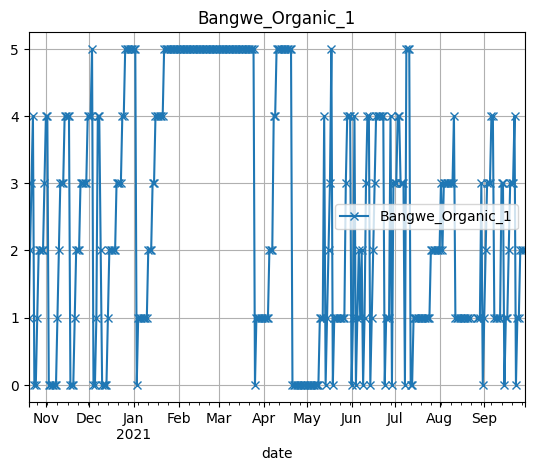

In [359]:
type = 2


totY = 4
totX = 4
if type == 1:
    #print(skip_filling_df[skip_dfCol[9]])
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numSkips:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,1,2,3,4,5])
            axis[i, j].get_legend().remove()
    plt.show()
elif type == 2:
    skip_filling_df.plot(use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    plt.title(skip_filling_df.columns[binNum])
    plt.show()


## Ramp rates algo 1

In [414]:
## First attempt

skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy()
#print(skip_filling_interest)


#print(skip_filling_df)
diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1)
diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1)

#number assignments
fives = (skip_filling_interest == 5)
fours = (skip_filling_interest == 4)
ones = (skip_filling_interest == 1)
zeros = (skip_filling_interest == 0)

#Fetches first available top values of each ramp
topvals_4 = fours*(diff_pos != 0) #four where previous value is not a four
topvals_5 = fives*(diff_pos !=0) * (diff_pos!=1) #fives where previous value is neither a five nor a four

#Fetches first available bottom values
bottomvals_0 = zeros*(diff_pos != 0) #zeros where the previous value is not a zero
bottomvals_1 = ones*(diff_pos != 0) *  (diff_pos != 1) # * (diff_neg != 1) 
#Ones where previous value neither 1 or 0; comment --> (next value not 1)




#Aggregate bottomvals & topvals separately and only keep true value indices
bottomvals = bottomvals_0+bottomvals_1
print(bottomvals)
bottomvals = bottomvals[bottomvals]
print(bottomvals)
topvals = topvals_5+topvals_4
topvals = topvals[topvals]


#Multiply with the value of the bottom/topval
bottomvals = bottomvals * skip_filling_interest
topvals = topvals * skip_filling_interest


mainvals = pd.concat([bottomvals.dropna(), topvals.dropna()]).sort_index().to_frame()
# fig, ax = plt.subplots()
# mainvals.plot(use_index=True,grid=True,ax=ax, kind='line')
mainvals.columns = ['values']
mainvals['diff'] = mainvals['values'].diff()
# mainvals = mainvals.drop(mainvals[(mainvals['diff'] < 3) & (mainvals['diff'] > 0)].index)

# mainvals['diff'] = mainvals['values'].diff()
# mainvals = mainvals.drop(mainvals[(mainvals['diff'] < 3) & (mainvals['diff'] > 0)].index)

mainvals['timediff'] = mainvals.index.to_series().diff()
firstrow = mainvals.first('1D')
mainvals = mainvals.dropna()
mainvals = pd.concat([firstrow, mainvals]).sort_index()
mainvals['der'] = mainvals['diff']/mainvals['timediff'].dt.days

#print(mainvals)
#return mainvals, bottomvals,topvals
#print(skip_filling_df.columns)


fig, ax = plt.subplots()
#mainvals, bottomvals, topvals = detectDrop()
increase = mainvals[(mainvals['der']>0)]
increasemean = increase['der'].mean()
#print(increase)
#print(increasemean)
# mainvals =pd.concat([bottomvals.dropna(),topvals.dropna()]).sort_index()
skip_filling_interest.plot(use_index=True, marker='x',grid=True,ax=ax, kind='line')
#topvals.plot(use_index=True,grid=True,ax=ax, style='.')
mainvals['values'].plot(use_index=True,grid=True,ax=ax, kind='line')
topvals.plot(use_index=True,grid=True,ax=ax, style='.')
bottomvals.plot(use_index=True,grid=True,ax=ax, style='.')

#print(skip_filling_df.columns[binNum])
# increase.to_csv('csvs/'+skip_filling_df.columns[binNum]+'.csv')
# plt.savefig('figures/'+skip_filling_df.columns[binNum]+'png')
plt.show()
# plt.close('all')

NameError: name 'binNum' is not defined

In [11]:
binNum =0

## Ramp rates algo 2

In [15]:
## Attempt at ramping
## Goals:
## - Remove spikes (n-> m!=n -> n)
## - 
skip_filling_interest = skip_filling_df[skip_dfCol[binNum]].copy().dropna()
diff_pos = skip_filling_interest.diff() #difference val(n) - val(n-1)
diff_neg = skip_filling_interest.diff(periods=-1) #difference val(n) - val(n+1)
td_1 = pd.Timedelta(1, "d")


## Removing 1 day back to original spikes (positive and negative) Forward pass
diff_index_pos = skip_filling_interest.index.to_series().diff()
diff_index_neg = skip_filling_interest.index.to_series().diff(periods=-1)
skip_filling_interest_no_spike = skip_filling_interest.drop(skip_filling_interest[diff_pos - diff_neg == 0][diff_index_pos == td_1][diff_index_neg == -td_1][diff_pos != 0].index)


## Top ends - forward pass
diff_index_pos = skip_filling_interest_no_spike.index.to_series().diff()
diff_index_neg = skip_filling_interest_no_spike.index.to_series().diff(periods=-1)
diff_pos = skip_filling_interest_no_spike.diff() #difference val(n) - val(n-1)
diff_neg = skip_filling_interest_no_spike.diff(periods=-1) #difference val(n) - val(n+1)
skip_filling_interest_no_spike = skip_filling_interest_no_spike.drop(skip_filling_interest_no_spike[diff_pos <= -1][diff_neg <= diff_pos][diff_index_pos == td_1][diff_index_neg == -td_1][diff_pos != 0].index)
indices_no_spike = skip_filling_interest_no_spike.index
i = 0
imax = 0
top_ends = pd.DataFrame(columns=['top_ends'])
while i <= len(indices_no_spike) and imax < 600:
    #print(i)
    imax = imax+1
    for j in range(len(indices_no_spike)-i-1):
        #if i+j > len(indices_no_spike):
        #    print('done')
        #    break
        if skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] >= skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]:
            if i+j+1 == len(indices_no_spike)-1:
                top_ends.loc[indices_no_spike[i+j+1]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]]
                i = i+j+1
                break
            elif skip_filling_interest_no_spike.loc[indices_no_spike[i+j]] == 4 and skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5:
                top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
                imax2 = 0
                while skip_filling_interest_no_spike.loc[indices_no_spike[i+j+1]] == 5 and imax2 < 600:
                    imax2 = imax2+1
                    if i+j+1 <= len(indices_no_spike)-1:
                        j = j+1
                    else:
                        print('broke oups')
                        break
                i = i + j + 1
                break
            else:
                pass
            #print('going up at')
            #print(indices_no_spike[i+j])
        else:
            #print('broke at')
            #print(indices_no_spike[i+j])
            top_ends.loc[indices_no_spike[i+j]] = skip_filling_interest_no_spike.loc[indices_no_spike[i+j]]
            i = i+j+1
            #print(i)
            break
print(imax2)
## Move top ends to top beginnings, eliminates plateau from analysis. Backward pass
top_beginnings = pd.DataFrame(columns=['top_beginnings'])
i = len(top_ends)-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_ends.index[i])):
        if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] == skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
            pass
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j-1]] < skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]:
            top_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_ends.index[i])-j]]
            i = i - 1
            #add to list 
            break
        else:
            i = i - 1
            break

## Remove derating (backward pass)
top_beginnings_no_derating = pd.DataFrame(columns=['top_beginnings_no_derating'])
i = len(top_beginnings[top_beginnings==5])-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])):
        if skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] == 4:
            pass
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])-j-1]] < 4:
            top_beginnings_no_derating.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings[top_beginnings==5].index[i])]]
            i = i - 1
            #add to list 
            break
        else:
            i = i - 1
            break

## Find bottoms (backward pass) walk back for as long as it decreases or equals previous
bottom_beginnings = pd.DataFrame(columns=['top_beginnings_no_derating'])
i = len(top_beginnings_no_derating)-1
imax = 0
while i >= 0 and imax < 600:
    imax = imax+1
    for j in range(indices_no_spike.get_loc(top_beginnings_no_derating.index[i])):
        if indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1 == 0:
            bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
            i = i - 1
            break
        elif skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j-1]] <= skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]:
            pass
        else:
            bottom_beginnings.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]] = skip_filling_interest_no_spike.loc[indices_no_spike[indices_no_spike.get_loc(top_beginnings_no_derating.index[i])-j]]
            i = i - 1
            #add to list 
            break
top_beginnings_no_derating.sort_index(inplace = True)
bottom_beginnings.sort_index(inplace = True)

tops = top_beginnings_no_derating.reset_index()
tops.columns = ['index_top', 'value_top']
bottoms = bottom_beginnings.reset_index()
bottoms.columns = ['index_bottom', 'value_bottom']
new_df = pd.concat([bottoms,tops], axis = 1)

print((new_df.loc[0].value_top-new_df.loc[0].value_bottom)/(new_df.loc[0].index_top-new_df.loc[0].index_bottom).days)
print((new_df.loc[0].value_top))
print((new_df.loc[0].value_bottom))
list_mc = []
for i in new_df.values.tolist():
    tuple1 = [mdates.date2num(i[0].to_pydatetime()), i[1]]
    tuple2 = [mdates.date2num(i[2].to_pydatetime()), i[3]]
    list_mc.append([tuple1,tuple2])
#print(list_mc)

11
1.0
4.0
2.0


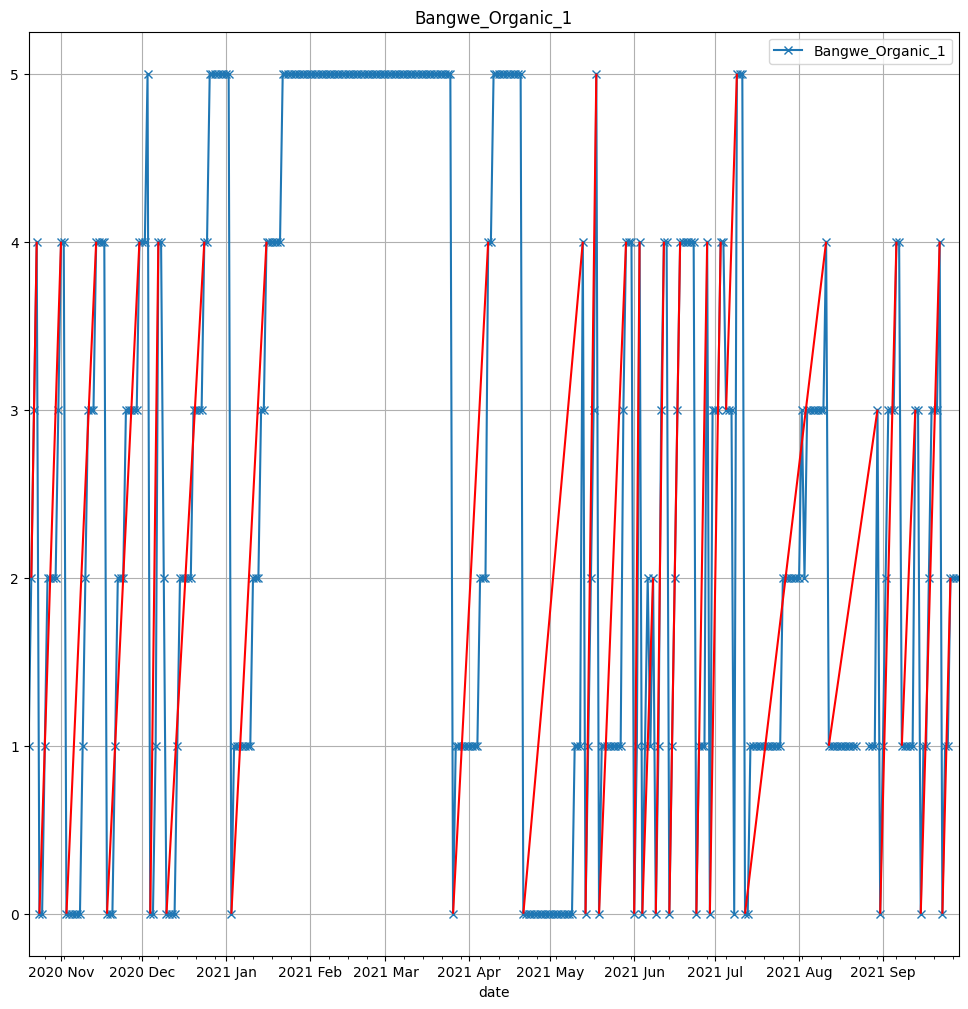

In [16]:
type = 2

totY = 4
totX = 4
if type == 1:
    print(skip_filling_df[skip_dfCol[binNum]])
    #print(skip_filling_df.columns)
    figure, axis = plt.subplots(totX, totY)
    for i in range(totX):
        for j in range(totY):
            if j+4*i >= numSkips:
                break
            skip_filling_df.plot(ax=axis[i, j], use_index=True, y=skip_dfCol[j + 4 * i], grid=True, marker='x')
            # doesn't show missing data i.e. long straight values are as such in raw data
            axis[i, j].set_title(skip_filling_df.columns[j + 4 * i])
            axis[i, j].set_yticks([0,1,2,3,4,5])
            axis[i, j].get_legend().remove()
    plt.show()
elif type == 2:
    fig, ax = plt.subplots(figsize=(12,12))
    skip_filling_df.plot(ax = ax,use_index=True, y=skip_dfCol[binNum], grid=True, marker='x')
    #skip_filling_interest_no_spike.plot(ax = ax,use_index=True, grid=True, marker='x')
    #top_ends.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    #top_beginnings.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    #top_beginnings_no_derating.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    #bottom_beginnings.plot(use_index=True, grid=True, marker='*', ax = ax, linestyle='none', markersize=12)
    lc = mc.LineCollection(list_mc, color='red')
    ax.add_collection(lc)
    plt.title(skip_filling_df.columns[binNum])
    ax.autoscale_view()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    monthFmt = mdates.DateFormatter("%Y %b")
    ax.xaxis.set_major_formatter(monthFmt)
    plt.show()